## IMPORTACIÓ INFORMACIÓ DE SABIO-RK

Generem un document csv on hi guardem els camps SabioReaction ID, Name, Role i Smiles de totes les reaccions químiques presents a la base de dades SABIO-RK. Seguidament importem els ECNumbers de cada reacció, ja que es troben en una altra URL i no ho podem importar tot junt. A continuació es crearà un script per tenir un document final amb les següents columnes: SabioReaction ID, Name, Role, Smiles i ECNumber.

In [71]:
#install
import requests
import pandas as pd 

from urllib.request import urlopen
from urllib.parse import quote

def CIRconvert(ids):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(ids) + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return 'Did not work'


import os.path 

datafile = "data/smiles.csv"

if os.path.exists(datafile): 
    print(datafile, " exists") 
else: 
    print("Generating ",datafile)

    QUERY_URL = 'http://sabiork.h-its.org/sabioRestWebServices/searchReactionParticipants'
 
    query = {"SabioReactionID":"*", "fields[]":["Name","Role", "Smiles" ]}

    request = requests.post(QUERY_URL, params = query) 
    request.raise_for_status() 

    print(request.text)

    # results

    fh=open(datafile, "w")

    fh.write(request.text)

#!head -35 data/smiles.csv > data/smilestest.csv #guardem les deu primeres reaccions per a fer proves



data/smiles.csv  exists


S'ha generat un document csv amb el nom: smiles.csv i s'ha desat a la carpeta data. 

In [12]:
smilesfile = "data/smiles.csv"
#smilesfile = "data/smilestest.csv"

Ens descarraguem els ECNumbers:

In [72]:
datafile = "data/ECnumber.csv"

if os.path.exists(datafile):
    print(datafile, "exists")
else:
    print("Generting", datafile)

    QUERY_URL = 'http://sabiork.h-its.org/sabioRestWebServices/searchReactionDetails' 

    query = {"SabioReactionID":"*", "fields[]":["SabioReactionID", "ECNumber"]} 

    # make GET request 
    request = requests.get(QUERY_URL, params = query) 
    request.raise_for_status() 

    #results 
    print(request.text) 

    fh=open("data/ECnumber.csv", "w")

    fh.write(request.text)

    df = pd.read_csv("data/ECnumber.csv", sep='\t')
    df1 = df.sort_values('SabioReactionID')
    print(df1)

data/ECnumber.csv exists


S'ha generat un fitxer amb els ECNumbers de cada element (reactiu, producte). El fitxer s'ha guardat amb el nom ECnumber.csv dins la carpeta data.

Ajuntem els dos documents csv per obtenir el document csv final amb les columnes, SabioReaction ID, Name, Role, Smiles i ECNumber, utilitzant la instrucció "merged".

In [73]:
input1=smilesfile
input2='data/ECNumber.csv'

df1 = pd.read_csv(input1, sep='\t')
df2 = pd.read_csv(input2, sep="\t")

# Merge the two dataframes on the common column "numbers"
merged_df = pd.merge(df1, df2, on="SabioReactionID")

# Write the merged dataframe to a new CSV file
merged_df.to_csv("data/SmilesEC.csv", index=False)

## Generem un DF curt per a fer proves

Crear smiles reacció:

Generem un fitxer només per fer proves i agilitzar el procés. En aquest fitxer només es tenen en compte les 10 primeres reaccions presents a SABIO-RK. El document generat s'anomena: smilestest.csv a partir del qual es genera el document de reaccions: ReactionSmilesTest.csv. 

In [80]:

input= "data/smilestest.csv"
output='data/ReactionSmilesTest.csv'

df1 = pd.read_csv(input, sep='\t')

#Volem eliminar tota la informació de les reaccions que tinguin algun valor nul en els seus subtrats i productes a la columna smiles.

#Primer afegim 0 on tronem valors NaN a la columna Smiles del dataframe.
df1['Smiles'] = df1['Smiles'].fillna(0)


# generem una llista buida on guardarem el SabioReactionID dels substrats i productes que s'hagin d'elimianr 
list1 = [] 

# iterem el df1   
for i in range(len(df1)): 

    # Si Smiles es igual a 0 afegim el SabioReactionID a la list1 
    if df1.loc[i,'Smiles'] == 0: 
        list1.append(df1.loc[i,'SabioReactionID']) 

#Eliminem del df1 tots els substrats i productes que tinguin el SabioReactionID igual que el que s'ha guardat a la llista
df = df1.drop(df1[df1['SabioReactionID'].isin(list1)].index) 


#A partir del dataframe sense missing values generem el dataframe curt per fer proves.
#Generem un dataframe buit amb les columnes SabioID i Reaction de 11 files.
df = df.reset_index()  #la funció rest_index() restableix l'índex del dataframe, estableix una llista del 0 fins a la longitud del dataframe
numrows=11
df2 = pd.DataFrame(columns=["SabioReactionID", "Reaction"]) #, index=range(numrows))
#print(df2)

#Creem dues llistes buides amb tants strings com files (en aquest cas 11 numrows=11). Generem una llista R per guardar els reactius i una llista P per guardar els productes.
R=[""]*(numrows+1)
P=[""]*(numrows+1)
isFirstR=[True]*(numrows+1)
isFirstP=[True]*(numrows+1)

def check_smiles(smiles):
    print(smiles)
    if not smiles:
        print('Wrong SMILES for:',smiles)
        return 0
    return 1

#Fem una iteració per cada fila del dataframe amb el command: for index, row in df.iterrows():
for index, row in df.iterrows():
    rid=row['SabioReactionID']
    name=row["Name"]
    smiles=row["Smiles"]
    if check_smiles(smiles) == 0:
        break
   
    role=row["Role"]
    if role == "Substrate": 
        if isFirstR[rid]:
            R[rid]=R[rid] + smiles 
            isFirstR[rid]= False
        else:
            R[rid]=R[rid] + "." + smiles       
        
    elif role == "Product":
        if isFirstP[rid]:
            P[rid]=P[rid]+smiles
            isFirstP[rid]=False
        else:
            P[rid]=P[rid] +"."+ smiles
    else:
        print("error, name")
    print(R[rid],P[rid])
    df2.at[rid, "SabioReactionID"]=rid

for i in range(numrows):
    print(R[i]+">"+P[i])
    df2.at[i, "Reaction"]=R[i]+">>"+P[i]


df2.drop(df2.tail(2).index,inplace=True)
print(df2)

#obtenim ReactionSmilesTest.csv.
df2.to_csv(output)



C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O)OP(=O)(O)O
C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O)OP(=O)(O)O 
C([C@@H]1[C@H]([C@@H]([C@](O1)(CO)O)O)O)OP(=O)(O)O
C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O)OP(=O)(O)O C([C@@H]1[C@H]([C@@H]([C@](O1)(CO)O)O)O)OP(=O)(O)O
Nc3ncnc1c3(ncn1C2OC(COP(O)(=O)OP(O)(=O)OP(O)(O)=O)C(O)C2(O))
Nc3ncnc1c3(ncn1C2OC(COP(O)(=O)OP(O)(=O)OP(O)(O)=O)C(O)C2(O)) 
OC1C(COP(O)(O)=O)OC(O)(COP(O)(O)=O)C1(O)
Nc3ncnc1c3(ncn1C2OC(COP(O)(=O)OP(O)(=O)OP(O)(O)=O)C(O)C2(O)) OC1C(COP(O)(O)=O)OC(O)(COP(O)(O)=O)C1(O)
Nc3ncnc1c3(ncn1C2OC(COP(O)(=O)OP(O)(O)=O)C(O)C2(O))
Nc3ncnc1c3(ncn1C2OC(COP(O)(=O)OP(O)(=O)OP(O)(O)=O)C(O)C2(O)) OC1C(COP(O)(O)=O)OC(O)(COP(O)(O)=O)C1(O).Nc3ncnc1c3(ncn1C2OC(COP(O)(=O)OP(O)(O)=O)C(O)C2(O))
C([C@@H]1[C@H]([C@@H]([C@](O1)(CO)O)O)O)OP(=O)(O)O
Nc3ncnc1c3(ncn1C2OC(COP(O)(=O)OP(O)(=O)OP(O)(O)=O)C(O)C2(O)).C([C@@H]1[C@H]([C@@H]([C@](O1)(CO)O)O)O)OP(=O)(O)O OC1C(COP(O)(O)=O)OC(O)(COP(O)(O)=O)C1(O).Nc3ncnc1c3(ncn1C2OC(COP(O)(=O)OP(O)(O)=O)C(O)C2(O))
[

Obtenim el document Test amb les reaccions i els ECNumbers.

In [85]:
input1="data/ReactionSmilesTest.csv"
input2='data/ECnumber.csv'

df1 = pd.read_csv(input1, sep=',')
df2 = pd.read_csv(input2, sep="\t")

# Merge the two dataframes on the common column "numbers"
merged_df = pd.merge(df1, df2, on="SabioReactionID")

# Write the merged dataframe to a new CSV file
merged_df.to_csv("data/ReactionSmilesECTest.csv", index=False)

# Es crea document ReactionSmiles

A partir del document SmilesEC es genera un fitxer amb les reaccions.

In [83]:
input= "data/SmilesEC.csv"
output='data/ReactionSmiles.csv'

df1 = pd.read_csv(input, sep=',')

#Volem eliminar tota la informació de les reaccions que tinguin algun valor nul en els seus subtrats i productes a la columna smiles i a la columna de ECNumber.

#Primer afegim 0 on tronem valors NaN a la columna Smiles del dataframe.
df1['Smiles'] = df1['Smiles'].fillna(0)
df1["ECNumber"]= df1["ECNumber"].fillna(0)


# generem una llista buida on guardarem el SabioReactionID dels substrats i productes que s'hagin d'elimianr 
list1 = [] 

# iterem el df1   
for i in range(len(df1)): 

    # Si Smiles es igual a 0 afegim el SabioReactionID a la list1 
    if df1.loc[i,'Smiles'] == 0:
        list1.append(df1.loc[i,'SabioReactionID']) 
#Eliminem del df1 tots els substrats i productes que tinguin el SabioReactionID igual que el que s'ha guardat a la llista
df = df1.drop(df1[df1['SabioReactionID'].isin(list1)].index) 

print(df1)

#A partir del dataframe sense missing values generem el dataframe curt per fer proves.
#Generem un dataframe buit amb les columnes SabioID i Reaction de 11 files.
df = df.reset_index()  #la funció rest_index() restableix l'índex del dataframe, estableix una llista del 0 fins a la longitud del dataframe
numrows=16513

df2 = pd.DataFrame(columns=["SabioReactionID", "Reaction"]) #, index=range(numrows))

#Creem dues llistes buides amb tants strings com files (en aquest cas 11 numrows=11). Generem una llista R per guardar els reactius i una llista P per guardar els productes.
R=[""]*(numrows+1)
P=[""]*(numrows+1)
isFirstR=[True]*(numrows+1)
isFirstP=[True]*(numrows+1)

def check_smiles(smiles):
    print(smiles)
    if not smiles:
        print('Wrong SMILES for:',smiles)
        return 0
    return 1

#Fem una iteració per cada fila del dataframe amb el command: for index, row in df.iterrows():
for index, row in df.iterrows():
    rid=row['SabioReactionID']
    name=row["Name"]
    smiles=row["Smiles"]
    if check_smiles(smiles) == 0:
        break
   
    role=row["Role"]
    if role == "Substrate": 
        if isFirstR[rid]:
            R[rid]=R[rid] + smiles 
            isFirstR[rid]= False
        else:
            R[rid]=R[rid] + "." + smiles       
        
    elif role == "Product":
        if isFirstP[rid]:
            P[rid]=P[rid]+smiles
            isFirstP[rid]=False
        else:
            P[rid]=P[rid] +"."+ smiles
    else:
        print("error, name")
    print(R[rid],P[rid])
    df2.at[rid, "SabioReactionID"]=rid

for i in range(numrows):
    print(R[i]+">"+P[i])
    df2.at[i, "Reaction"]=R[i]+">>"+P[i]

  

df2.drop(df2.tail(2).index,inplace=True)
print(df2)

#obtenim ReactionSmiles.csv.
df2.to_csv(output)

       SabioReactionID                              Name       Role  \
0                    1       alpha-D-Glucose 6-phosphate  Substrate   
1                    1       beta-D-Fructose 6-phosphate    Product   
2                    2                               ATP  Substrate   
3                    2  beta-D-Fructose 1,6-bisphosphate    Product   
4                    2                               ADP    Product   
...                ...                               ...        ...   
52642            16513                                H+    Product   
52643            16513                                O2  Substrate   
52644            16513                                CO    Product   
52645            16513      2-Heptyl-3-hydroxy-quinolone  Substrate   
52646            16513        n-Octanoylanthranilic acid    Product   

                                                  Smiles  ECNumber  
0      C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O)O...   5.3.1.9  
1      C(

S'afageix els ECNumber de cada reacció. 

In [84]:
input1="data/ReactionSmiles.csv"
input2='data/ECnumber.csv'

df1 = pd.read_csv(input1, sep=',')
df2 = pd.read_csv(input2, sep="\t")

# Merge the two dataframes on the common column "numbers"
merged_df = pd.merge(df1, df2, on="SabioReactionID")

# Write the merged dataframe to a new CSV file
merged_df.to_csv("data/ReactionSmilesEC.csv", index=False)

Per poder traball amb RDKit i obtenir les _features_ de cada substància necessitem un csv amb els SMILES de cada substrat i producte per separat. En el següent script eliminem els Smiles de les molècules que es trobin duplicades.

In [86]:
input= smilesfile
output='data/moleculesSmilesTest.csv'

df1 = pd.read_csv(input, sep='\t')

df1['Smiles'] = df1['Smiles'].fillna(0)
# creem uns llista buida.  
list1 = [] 
#smiles=row["Smiles"]   
for i in range(len(df1)): 

    # comprovem si Smiles és igual a 0, llavors afegim el valors SabioReactionID a la llista list1 
    if df1.loc[i,'Smiles'] == 0: 
        list1.append(df1.loc[i,'SabioReactionID']) 

df = df1.drop(df1[df1['SabioReactionID'].isin(list1)].index) 
# Print the updated dataframe 
#print(df)

dfmolecules = df.drop_duplicates(subset="Smiles")

print(dfmolecules)
dfmolecules.to_csv(output)

       SabioReactionID                                   Name       Role  \
0                    1            alpha-D-Glucose 6-phosphate  Substrate   
1                    1            beta-D-Fructose 6-phosphate    Product   
2                    2                                    ATP  Substrate   
3                    2       beta-D-Fructose 1,6-bisphosphate    Product   
4                    2                                    ADP    Product   
...                ...                                    ...        ...   
62233            16502                        10-Formylfolate  Substrate   
62256            16507  15-Keto-prostaglandin E2 methyl ester    Product   
62257            16507          Prostaglandin E2 methyl ester  Substrate   
62294            16513           2-Heptyl-3-hydroxy-quinolone  Substrate   
62295            16513             n-Octanoylanthranilic acid    Product   

                                                  Smiles  
0      C([C@@H]1[C@H]([C@@H]

# RDKit
 És una llibreria de codi obert de química computacional de python. Està dissenyat per a la manipulació de molècules i estructures químiques. RDKit té moltes funcions algunes d'elles són la conversió entre diferents formats de fitxers de molècules, la generació d'estructures moleculars, el càlcul de propietats físico-químiques de les molècules, com ara la solubilitat, el pes molecular, el nombre d'àtoms rotatius, la càrrega, etc. També permet generar visualitzacions 2D i 3D de molècules. Nosaltres l'utilizarem per a obtenir les _features_ , propietats fisico-químiques, que ens serviran de _finguerprints_ per a la generació del model ML. 

 Descriptors RDKit:

- Pes molecular: El pes molecular d'una molècula pot estar relacionat amb la seva activitat enzimàtica, ja que les molècules més grans o més complexes poden tenir més probabilitats d'interaccionar amb enzims específics. 

- Lipofílicitat: Capacitat d'un compost a dissoldre's en lípids o dissolvents no polars.

- Àrea de superfície polar topològica (TPSA) Chem.Descriptors.TPSA(): és una mesura de l'àrea superficial d'una molècula que és polar o capaç de participar en l'enllaç d'hidrogen. La TPSA pot estar relacionada amb l'activitat enzimàtica, ja que molts enzims tenen llocs actius polars o carregats. 

- Nombre d'heteroàtoms. NumHeteroatoms()

- Nombre d'anells. RingCount()

- Nombre d'anells aromàtis. NumAromaticRings()

- Nombre d'àtoms pesants: Chem.Descriptors.HeavyAtomCount(mol)

- Nombre d'anells alifàtics: Chem.Descriptors.NumAliphaticRings(mol)

- Fraction of carbons that are sp3 hybridized: Chem.Descriptors.FractionCSP3(mol)

- Number of chiral centers: Chem.Descriptors.NumChiralCenters(mol)

- Balaban J index: Chem.Descriptors.BalabanJ(mol) : L'índex J de Balaban mesura el grau d'insaturació d'una molècula. Està relacionat amb la reactivitat química i l'estabilitat d'una molècula, així com amb la seva aromaticitat. Les molècules amb índex més alts tendeixen a tenir graus més alts d'insaturació i, per tant, són més reactives mentre que les molècules amb índex més baixos solen ser més estables.

- Number of rotatable bonds: Chem.Descriptors.NumRotatableBonds(mol)

In [87]:
from rdkit import Chem
from rdkit.Chem import Crippen, Descriptors
import matplotlib.pyplot as plt

df1 = pd.read_csv('data/moleculesSmilesTest.csv', sep=',')
df1['mol']=df1['Smiles'].apply(lambda x: Chem.MolFromSmiles(x)) #transformem la columna "Smiles" en mol per començar a treballar amb RDKit
print(type(df1['mol'][0])) #comprovem que hem genereat la classe rdkit.Chem.rdchem.Mol

from rdkit import Chem
from rdkit.Chem import Crippen, Descriptors
output='data/fingerprintTest.csv'

mols = df1['mol']

def smiles_to_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol


def features(mol,data):
    #Extract properties using RDKit functions
    smiles = Chem.MolToSmiles(mol)
    formula = Chem.rdMolDescriptors.CalcMolFormula(mol)
    mw= Chem.rdMolDescriptors.CalcExactMolWt(mol) #pes molecular
    logp=Chem.Descriptors.MolLogP(mol)
    tpsa = Chem.rdMolDescriptors.CalcTPSA(mol)
    num_rc=Chem.Descriptors.RingCount(mol)
    num_AR=Chem.Descriptors.NumAromaticRings(mol)
    num_HAC=Chem.Descriptors.HeavyAtomCount(mol)
    num_AR=Chem.Descriptors.NumAliphaticRings(mol)
    CSP3=Chem.Descriptors.FractionCSP3(mol)
    BJI=Chem.Descriptors.BalabanJ(mol)
    num_RB=Chem.Descriptors.NumRotatableBonds(mol)
    num_hbd = Chem.rdMolDescriptors.CalcNumHBD(mol)
    num_hba = Chem.rdMolDescriptors.CalcNumHBA(mol)
   

    #Append results in a data list
    data.append([mw,logp, tpsa, num_rc, num_AR, num_HAC, num_AR, CSP3, BJI, num_RB, num_hbd, num_hba])
    return

data = []

for mol in mols:
    features(mol,data)
llistadescriptors=['MW','logP',"TPSA", "Rings Count", "Aromatic Rings", "Heavy atoms cout", "Alifatic Rings",  "CSP3",  "BalabanJ", "RotatableBonds", "H-bond donor", "H-bond acceptor"]
#We have a list with information. Creation of a Dataframe:
df= pd.DataFrame(data,columns=llistadescriptors)
#df["SabioReactionID"]= df1["SabioReactionID"]
#df["Role"]=df1["Role"]
#df["Name"]=df1["Name"]
df["Smiles"]=df1["Smiles"]

print(df)

df.to_csv(output)



[16:22:04] WARNING: not removing hydrogen atom without neighbors
[16:22:04] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[16:22:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:22:04] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:22:04] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:22:04] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
[16:22:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[16:22:04] Can't kekulize mol.  Unkekulized atoms: 7 9 22
[16:22:04] Can't kekulize mol.  Unkekulized atoms: 34 35 39 41 42
[16:22:04] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[16:22:04] Can't kekulize mol.  Unkekulized atoms: 36 37 38 39 40 41 42 43 44
[16:22:04] Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 43
[16:22:04] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[16:22:04] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 11
[16:22:04] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 12
[16:22:04] Can't k

<class 'rdkit.Chem.rdchem.Mol'>


[16:22:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[16:22:05] Can't kekulize mol.  Unkekulized atoms: 48 49 50 51 52
[16:22:05] Can't kekulize mol.  Unkekulized atoms: 49 50 51 52 53
[16:22:05] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
[16:22:05] SMILES Parse Error: syntax error while parsing: [C@@H]1(N2C3=C(C(=NC=N3)N)N=C2)O[C@H](COP(OP(OCC(C)([C@H](C(NCCC(NCCSC(=O)CC[C@@](C)([C@]4(CC[C@@]5([C@@]4(CC[C@@]6([C@]7(CC[C@H](C[C@]7(CC[C@@]56[H])[H])O)C)[H])C)[H])[H])[H])=O)=O)O)C)(=O)O)(=O)O)[C @H]([C@H]1O)OP(O)(O)=O
[16:22:05] SMILES Parse Error: Failed parsing SMILES '[C@@H]1(N2C3=C(C(=NC=N3)N)N=C2)O[C@H](COP(OP(OCC(C)([C@H](C(NCCC(NCCSC(=O)CC[C@@](C)([C@]4(CC[C@@]5([C@@]4(CC[C@@]6([C@]7(CC[C@H](C[C@]7(CC[C@@]56[H])[H])O)C)[H])C)[H])[H])[H])=O)=O)O)C)(=O)O)(=O)O)[C @H]([C@H]1O)OP(O)(O)=O' for input: '[C@@H]1(N2C3=C(C(=NC=N3)N)N=C2)O[C@H](COP(OP(OCC(C)([C@H](C(NCCC(NCCSC(=O)CC[C@@](C)([C@]4(CC[C@@]5([C@@]4(CC[C@@]6([C@]7(CC[C@H](C[C@]7(CC[C@@]56[H])[H])O)C)[H])C)[H]

ArgumentError: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)

In [89]:
input1="data/reactions_with_descriptors.csv"
input2='data/ECNumber.csv'

df1 = pd.read_csv(input1, sep=',')
df2 = pd.read_csv(input2, sep="\t")

# Merge the two dataframes on the common column "numbers"
merged_df = pd.merge(df1, df2, on="SabioReactionID")

# Write the merged dataframe to a new CSV file
merged_df.to_csv("data/R_w_D_T.csv", index=False)

Fem un estudi histogràfic dels diferents descriptors (en aquest cas com que estem treballant amb el document de prova i tenim poques molècules els gràfics no són representatius.):

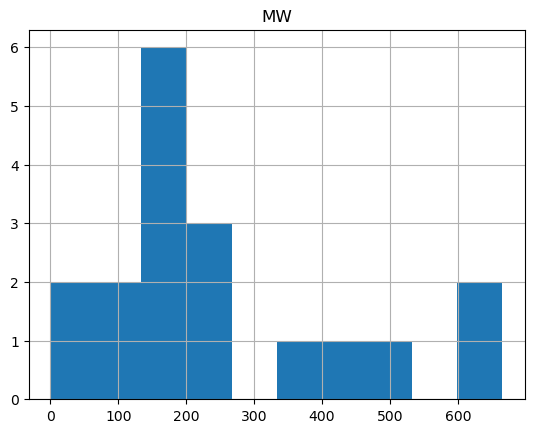

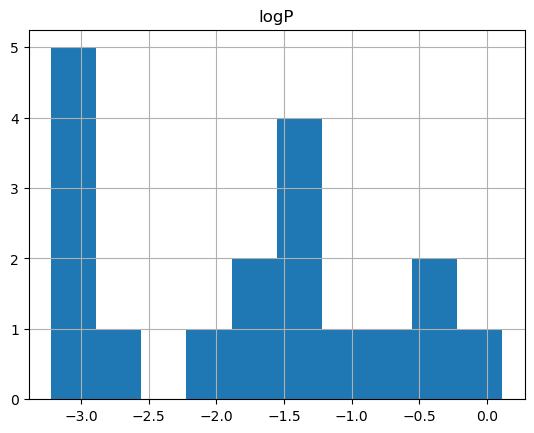

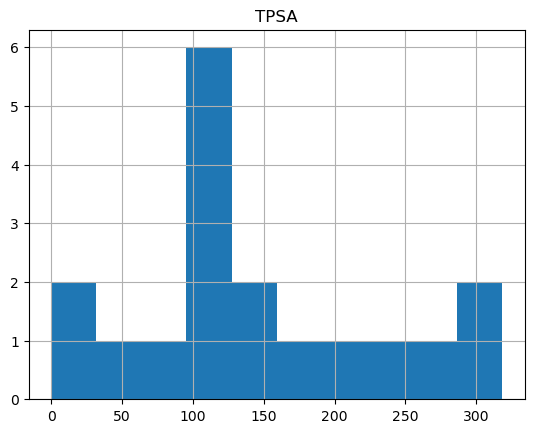

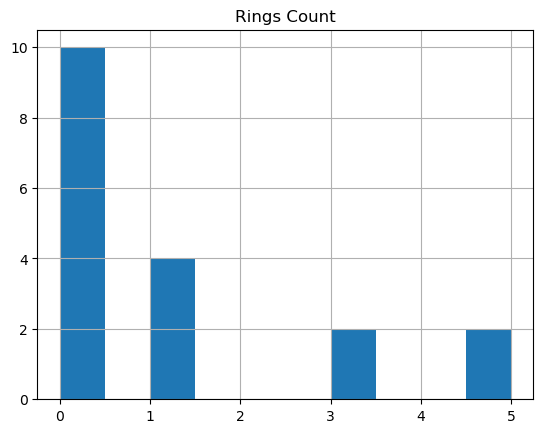

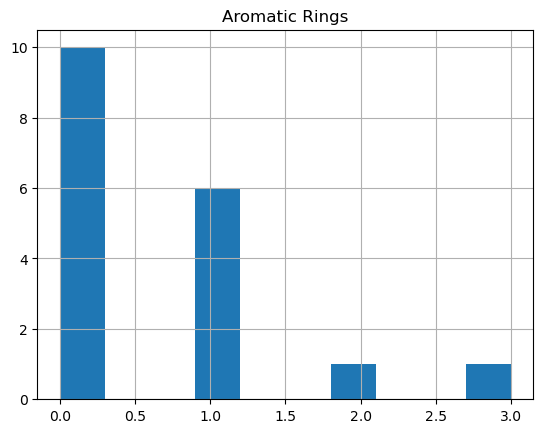

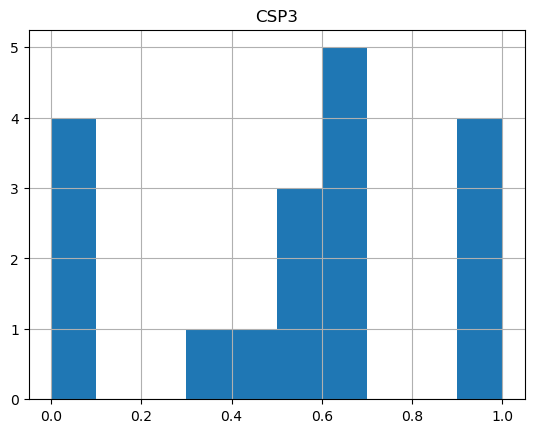

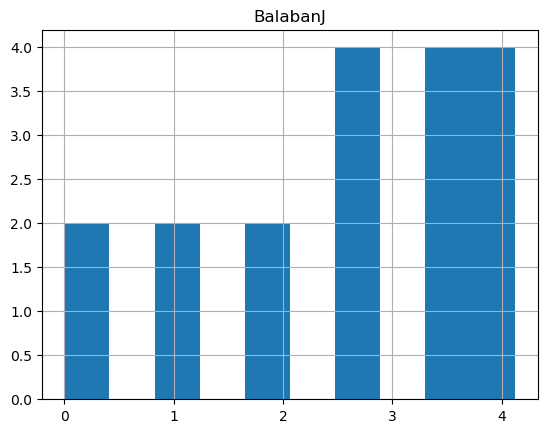

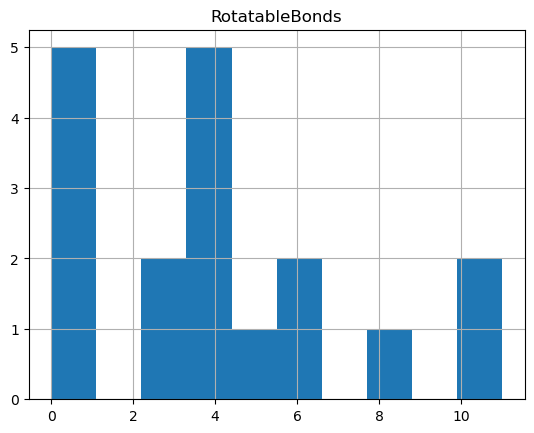

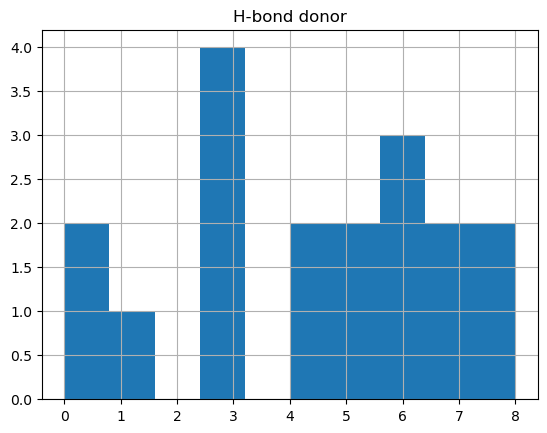

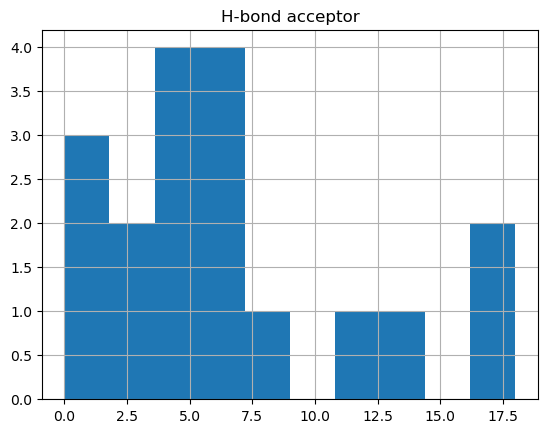

In [10]:
hist1=df.hist(column='MW')
hist2=df.hist(column='logP')
hist3=df.hist(column='TPSA')
hist4=df.hist(column='Rings Count')
hist5=df.hist(column='Aromatic Rings')
hist6=df.hist(column='CSP3')
hist7=df.hist(column='BalabanJ')
hist8=df.hist(column='RotatableBonds')
hist9=df.hist(column='H-bond donor')
hist10=df.hist(column='H-bond acceptor')


Generem un fitxer csv per introduir al programa Chemprop. El fitxer ha de tenir la columna: ReactionSmiles Sabio ID i la suma de fingerprints dels seus substrats i productes. 

In [88]:
import pandas as pd

input2 = 'data/FingerprintTest.csv'
input1 = 'data/ReactionSmilesTest.csv'
output= 'data/output_file.csv'

df2 = pd.read_csv(input2, sep=',')
df1 = pd.read_csv(input1, sep=',')

#generem un diccionari que assigni les cadenes SMILES als valors dels descriptors
molecule_descriptors = df2.set_index('Smiles').to_dict('index')

# Funció per afegir descriptors a les reaccions.
def add_descriptors(row):
    reaction_smiles = row['Reaction']
    reactants, products = reaction_smiles.split('>>')
    reactant_smiles = reactants.split('.')
    product_smiles = products.split('.')
    llistadescriptors=['MW','logP',"TPSA", "Rings Count", "Aromatic Rings", "Heavy atoms cout", "Alifatic Rings",  "CSP3",  "BalabanJ", "RotatableBonds", "H-bond donor", "H-bond acceptor"]
    reactrow=pd.Series([0]*12,index=llistadescriptors)
    productrow=pd.Series([0]*12,index=llistadescriptors)
    
    
    # Recorre cada reactiu i producte i s'afegeixen els descriptors si aquests es troben al diccionari de descriptors de molècules
    for reactant in reactant_smiles:
       # print(reactant)
        ser2=pd.Series(molecule_descriptors[reactant]).drop(labels=['Unnamed: 0']) #eliminem la columna Unnamed i fem la sumna  dels valors de cada variable dels reactius.
        #print('pd.Series\n',ser2)
        reactrow=reactrow.add(ser2)
    for product in product_smiles:
        ser2=pd.Series(molecule_descriptors[product]).drop(labels=['Unnamed: 0']) #eliminem la columna Unnamed i fem la suma dels valors de cada variable dels productes.
        productrow=productrow.add(ser2)
    row = pd.concat([row, reactrow, productrow])#, ignore_index=True)
    return row



# Apliquem la funció add_descriptors a cada fila del dataframe de reaccions.
reactions_df = df1.apply(add_descriptors, axis=1)

#print(reactions_df)

# escrivim el dataframe en un csv.
reactions_df.to_csv('data/reactions_with_descriptors.csv', index=False)

In [ ]:
import pandas as pd

input2 = 'data/FingerprintTest.csv'
input1 = 'data/ReactionSmilesTest.csv'
output= 'data/output_file.csv'

df2 = pd.read_csv(input2, sep=',')
df1 = pd.read_csv(input1, sep=',')

#create a dictionary mapping SMILES strings to descriptor values
molecule_descriptors = df2.set_index('Smiles').to_dict('index')

# function to add descriptors to reactions
def add_descriptors(row):
    reaction_smiles = row['Reaction']
    reactants, products = reaction_smiles.split('>')
    
    reactant_smiles = reactants.split('.')
    product_smiles = products.split('.')
    
    # loop over each reactant and product and add descriptors if they exist in the molecule_descriptors dictionary
    for reactant in reactant_smiles:
        if reactant in molecule_descriptors:
            row = row.append(pd.Series(molecule_descriptors[reactant]), ignore_index=True)
    for product in product_smiles:
        if product in molecule_descriptors:
            row = row.append(pd.Series(molecule_descriptors[product]), ignore_index=True)
    
    return row

# apply the add_descriptors function to each row in the reactions dataframe
reactions_df = df1.apply(add_descriptors, axis=1)

# write the updated reactions dataframe to a new CSV file
reactions_df.to_csv('reactions_with_descriptors.csv', index=False)

FUNCIONS CHEMPROP

CHEMPROP_RES=$HOME/scratch  #aqui li dones una variable amb un path
mkdir $CHEMPROP_RES #crees
wget http://www.bioinf.jku.at/research/lsc/index.html -O $HOME/data.tar.gz #home es una variable de la shell
tar zwf data.tar.gz #descomprimir i creara la carpeta data

# Train
python train.py  --data_path $CHEMPROP_RES/data/tox21.csv --dataset_type classification --save_dir $CHEMPROP_RES/tox21_checkpoint

# Predict
chemprop_predict --test_path $CHEMPROP_RES/data/tox21.csv --checkpoint_dir  $CHEMPROP_RES/tox21_checkpoint --preds_path $CHEMPROP_RES/tox21_preds.csv

# Interpret
chemprop_interpret --data_path $CHEMPROP_RES/data/tox21.csv --checkpoint_dir $CHEMPROP_RES/tox21_checkpoint/fold_0

In [ ]:
conda activate tfm

CHEMPROP_RES=$HOME/scratch  #aqui li dones una variable amb un path
mkdir $CHEMPROP_RES #crees
wget http://www.bioinf.jku.at/research/lsc/index.html -O $HOME/data.tar.gz #home es una variable de la shell
#tar zwf data.tar.gz #descomprimir i creara la carpeta data

# Train
python train.py  --data_path $CHEMPROP_RES/data/R_w_D_T.csv --dataset_type classification --save_dir $CHEMPROP_RES/tox21_checkpoint

# Predict
chemprop_predict --test_path $CHEMPROP_RES/data/tox21.csv --checkpoint_dir  $CHEMPROP_RES/tox21_checkpoint --preds_path $CHEMPROP_RES/tox21_preds.csv

# Interpret
chemprop_interpret --data_path $CHEMPROP_RES/data/tox21.csv --checkpoint_dir $CHEMPROP_RES/tox21_checkpoint/fold_0

In [95]:
import os
import chemprop
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA


reaction_reg_df=pd.read_csv("/Users/annacano/Documents/TFM/github/TFM_scripts/data/R_w_D_T.csv")
reaction_reg_df 

arguments = [
    "--data_path", "/Users/annacano/Documents/TFM/github/TFM_scripts/data/R_w_D_T.csv",
    "--dataset_type", "regression",
    "--epochs", "5",
    "--reaction",
    "--save_smiles_splits"
]

args=chemprop.args.TrainArgs().parse_args(arguments)
mean_score, std_socre = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

Command line
python /opt/anaconda3/envs/tfm/lib/python3.10/site-packages/ipykernel_launcher.py -f /Users/annacano/Library/Jupyter/runtime/kernel-92a87a82-0c08-480d-be24-0abb662536fd.json
Args
{'activation': 'ReLU',
 'adding_h': False,
 'aggregation': 'mean',
 'aggregation_norm': 100,
 'atom_descriptor_scaling': True,
 'atom_descriptors': None,
 'atom_descriptors_path': None,
 'atom_descriptors_size': 0,
 'atom_features_size': 0,
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'bias_solvent': False,
 'bond_feature_scaling': True,
 'bond_features_path': None,
 'bond_features_size': 0,
 'cache_cutoff': 10000,
 'checkpoint_dir': None,
 'checkpoint_frzn': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'class_balance': False,
 'config_path': None,
 'crossval_index_dir': None,
 'crossval_index_file': None,
 'crossval_index_sets': None,
 'cuda': False,
 'data_path': '/Users/annacano/Documents/TFM/github/TFM_scripts/data/R_w_D_T.csv',
 'data_weights_path': None,
 'data

ValueError: Inequality found in target data. To use inequality targets (> or <), the regression loss function bounded_mse must be used.